# import

In [1]:
import pandas as pd
from pandas import DataFrame
from os import sep
import numpy as np
import re
import csv
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [4]:
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,\
ExtraTreesClassifier,RandomForestClassifier,GradientBoostingRegressor,BaggingRegressor
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import optuna
from feature_engine.selection import RecursiveFeatureAddition
from feature_engine.selection import RecursiveFeatureElimination

from scipy.stats import pearsonr,uniform
from scipy.stats import median_absolute_deviation

from descriptor.OneHot import get_oh,des_std

In [5]:
def run_imap_mp(func, argument_list, num_processes='', is_tqdm=True):
    result_list_tqdm = []

    if num_processes == '':
        num_processes = multiprocessing.cpu_count()-3
    pool = multiprocessing.Pool(processes=num_processes)
    if is_tqdm:
        #from tqdm import tqdm
        for result in tqdm(pool.imap(func=func,iterable=argument_list),
                           total=len(argument_list)):
            result_list_tqdm.append(result)
    else:
        for result in pool.imap(func=func, iterable=argument_list):
            result_list_tqdm.append(result)
    pool.close()

    return result_list_tqdm

In [6]:
def pre_r2(model,tmp_des,tmp_lable):
    all_r2 = []
    np.random.seed(2023)
    for i in range(5):
        for train_index_tep,test_index_tep in kfold.split(tmp_des):
            train_x,test_x = tmp_des[train_index_tep],tmp_des[test_index_tep]
            train_y,test_y = tmp_lable[train_index_tep],tmp_lable[test_index_tep]
            model.fit(train_x,train_y)
            pre_y = model.predict(test_x)
            tmp_r2 = r2_score(pre_y,test_y)
            all_r2.append(tmp_r2)
    r2 = np.mean(np.array(all_r2))
    return r2

def pre_multi(tmp_input):
    index = tmp_input[0]
    model = tmp_input[1]
    tem_des_sel = tmp_input[2]
    des = tmp_input[3]
    lable = tmp_input[4]
    tem_des_sel_x = tem_des_sel+[index]
    tem_des = des[:,tem_des_sel_x]
    r2 = pre_r2(model,tem_des,lable)
    return [r2,tem_des_sel_x]

def circle(des,lable,model,des_len,tem_des_sel):
    all_r2=[]
    try_index = np.delete(np.array(range(des_len)),tem_des_sel)
    tmp_input = [(i,model,tem_des_sel,des,lable) for i in try_index]
    tmp_output = run_imap_mp(pre_multi,tmp_input,num_processes=64,is_tqdm=False)
    tmp_output.sort(key=lambda x:x[0],reverse=True)
    return tmp_output[0][0],tmp_output[0][1]

# data

In [8]:
df = pd.read_csv('dataset'+sep+'danmark.csv')
cat_smiles = np.array(df['Catalyst'].to_list())
imine_smiles = np.array(df['Imine'].to_list())
thiol_smiles = np.array(df['Thiol'].to_list())
labels = np.array(df['Output'].to_list())
labels_std = (labels - labels.min())/(labels.max()-labels.min())
labels_std_par = labels.max()-labels.min()
cat_smi_set = list(set(cat_smiles))
imine_smi_set = list(set(imine_smiles))
thiol_smi_set = list(set(thiol_smiles))
cat_smi_set.sort()
imine_smi_set.sort()
thiol_smi_set.sort()
df

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,CCS,0.501759
1,O=P1(O)OC2=C(C3=C(F)C=C(OC)C=C3F)C=C4C(C=CC=C4...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,CCS,1.074991
2,O=P1(O)OC2=C(C3=C(C)C=C(C)C=C3C)C=C4C(C=CC=C4)...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,CCS,1.179891
3,O=P1(O)OC2=C(C3=CC(C)=C(OC(C)C)C(C)=C3)C=C4C(C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,CCS,0.446374
4,O=P1(O)OC2=C(C3=CC=C(S(F)(F)(F)(F)F)C=C3)C=C4C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,CCS,0.530235
...,...,...,...,...
1070,O=P1(O)OC2=C(C3=CC(C(F)(F)F)=CC(C(F)(F)F)=C3)C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1CCCCC1,0.682601
1071,O=P1(O)OC2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C=...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1CCCCC1,1.743658
1072,O=P1(O)OC2=C(C3=C(C4CCCCC4)C=C(C5CCCCC5)C=C3C6...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1CCCCC1,1.743658
1073,O=P1(O)OC2=C(C3=C(C(C)C)C=C(C4=CC=C(C(C)(C)C)C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1CCCCC1,1.446325


# descriptors

## OH

In [9]:
cat_oh_desc=get_oh(cat_smiles)
imine_oh_desc=get_oh(imine_smiles)
thiol_oh_desc=get_oh(thiol_smiles)
oh_react_feat = np.concatenate([cat_oh_desc,imine_oh_desc,thiol_oh_desc],axis = 1)
oh_react_feat_std=des_std(oh_react_feat)

## path_OH

In [10]:
df_OH = pd.read_csv('descriptor'+sep+'des_danmark_path_onehot.csv')
dic_df_OH = df_OH.to_dict('list')
sta_path_OH_des_name = list(dic_df_OH.keys())[:]
sta_path_OH_des = np.transpose(list(dic_df_OH.values())[:])
descs_onehot = [sta_path_OH_des,oh_react_feat_std]
descs_onehot_names = ['path_OH','OH']

### ste_ele

In [11]:
df_ste_ele = pd.read_csv('descriptor'+sep+'des_danmark_ste_ele.csv')
dic_df_ste_ele = df_ste_ele.to_dict('list')
sta_path_ste_ele_des_name = list(dic_df_ste_ele.keys())[:]
sta_path_ste_ele_des = np.transpose(list(dic_df_ste_ele.values())[:])

# model

In [12]:
models = [BaggingRegressor(n_jobs=-1),
          tree.DecisionTreeRegressor(),ExtraTreesRegressor(n_jobs=-1),
          GradientBoostingRegressor(),
          KNeighborsRegressor(n_jobs=-1),KernelRidge(),
          LinearSVR(),RandomForestRegressor(n_jobs=-1),
          linear_model.Ridge(),SVR(C=1,epsilon=0.01,gamma='auto'),AdaBoostRegressor(),
          xgb.XGBRegressor(n_jobs=-1)]
model_names = ['BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge',
               'SVR','Ada','XGB']

kfold = KFold(n_splits=5,shuffle=True)

# One-Hot

### model selection

In [11]:
model_performance = {}
for model,model_name in zip(models,model_names):
    for desc,desc_name in zip(descs_onehot,descs_onehot_names): 
        all_r2 = []
        all_pearsr = []
        all_mae = []
        all_rmse= []
        repeat_pred = []
        repeat_test = []
        np.random.seed(2023)
        for i in range(5):
            for train_index_tep,test_index_tep in kfold.split(desc):
                train_x,test_x = desc[train_index_tep],desc[test_index_tep]
                train_y,test_y = labels_std[train_index_tep],labels_std[test_index_tep]
                model.fit(train_x,train_y)
                pre_y = model.predict(test_x)
                repeat_test.extend(list(test_y))
                repeat_pred.extend(list(pre_y))
                r2 = r2_score(pre_y,test_y)
                pearsr = pearsonr(pre_y,test_y)[0]
                mae = mean_absolute_error(pre_y,test_y)
                rmse=(mean_squared_error(pre_y,test_y))**(0.5)
                all_r2.append(r2)
                all_pearsr.append(pearsr)
                all_mae.append(mae)
                all_rmse.append(rmse)
        model_performance['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),
        np.mean(all_pearsr),np.mean(all_mae),np.mean(all_rmse),
        repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('''Model: %5s, Descriptor: %8s: R2: %.4f, MAE: %.4f, RMSE: %.4f,
        Pearson R: %.4f'''%(model_name,desc_name,np.mean(all_r2),np.mean(all_mae)
                            ,np.mean(all_rmse),np.mean(all_pearsr)))

Model:    BG, Descriptor:  path_OH: R2: 0.8873, MAE: 0.0434, RMSE: 0.0634,
        Pearson R: 0.9469
Model:    BG, Descriptor:       OH: R2: 0.8849, MAE: 0.0442, RMSE: 0.0641,
        Pearson R: 0.9457
Model:    DT, Descriptor:  path_OH: R2: 0.8589, MAE: 0.0490, RMSE: 0.0737,
        Pearson R: 0.9302
Model:    DT, Descriptor:       OH: R2: 0.8636, MAE: 0.0495, RMSE: 0.0730,
        Pearson R: 0.9323
Model:    ET, Descriptor:  path_OH: R2: 0.8654, MAE: 0.0476, RMSE: 0.0717,
        Pearson R: 0.9341
Model:    ET, Descriptor:       OH: R2: 0.8679, MAE: 0.0484, RMSE: 0.0712,
        Pearson R: 0.9352
Model:    GB, Descriptor:  path_OH: R2: 0.7779, MAE: 0.0549, RMSE: 0.0741,
        Pearson R: 0.9364
Model:    GB, Descriptor:       OH: R2: 0.7384, MAE: 0.0573, RMSE: 0.0768,
        Pearson R: 0.9364
Model:   KNR, Descriptor:  path_OH: R2: 0.7361, MAE: 0.0677, RMSE: 0.0875,
        Pearson R: 0.8965
Model:   KNR, Descriptor:       OH: R2: -0.8177, MAE: 0.1614, RMSE: 0.2093,
        Pearson

<AxesSubplot: >

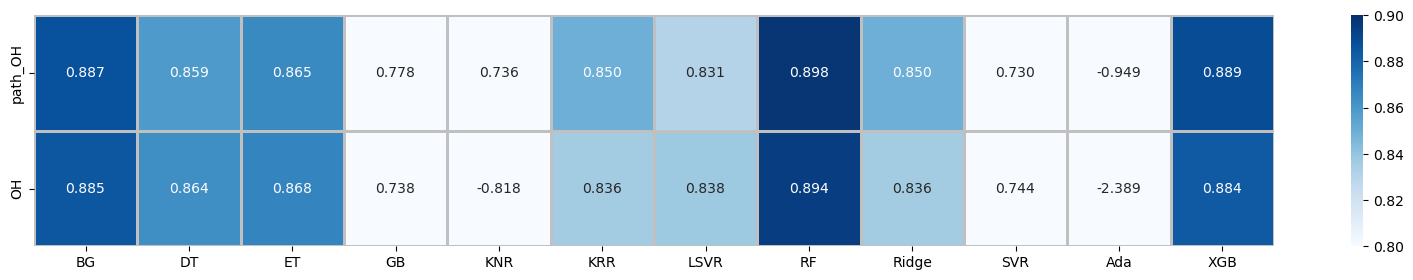

In [12]:
r2_map = np.zeros((len(descs_onehot_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(descs_onehot_names):
        r2_map[j,i] = model_performance['%s-%s'%(m,d)][0]

fig = plt.figure(figsize=(20,3))
sns.heatmap((r2_map),annot=True,fmt='.3f',xticklabels=model_names,
            yticklabels=descs_onehot_names,cmap='Blues',vmin=0.8,vmax=0.9,
            linewidths=1,linecolor='silver')

<AxesSubplot: >

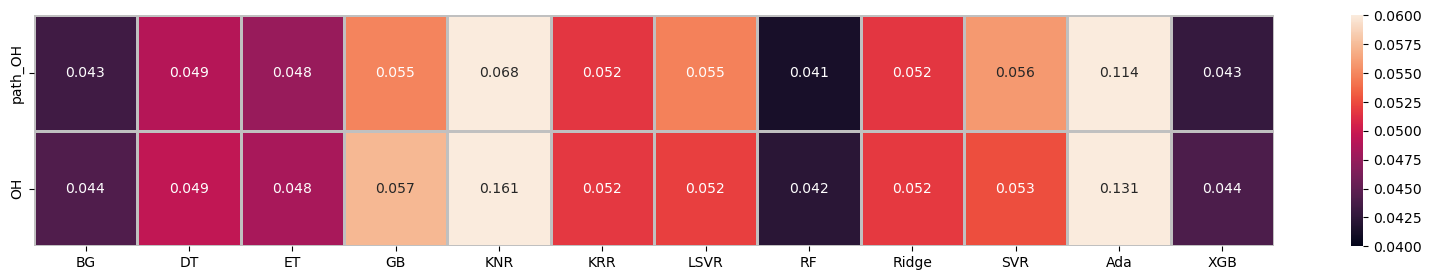

In [13]:
r2_map = np.zeros((len(descs_onehot_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(descs_onehot_names):
        r2_map[j,i] = model_performance['%s-%s'%(m,d)][2]

fig = plt.figure(figsize=(20,3))
sns.heatmap((r2_map),annot=True,fmt='.3f',xticklabels=model_names,
            yticklabels=descs_onehot_names,vmin=0.04,vmax=0.06,
            linewidths=1,linecolor='silver')

# ste_ele

In [10]:
with open('result'+sep+'ste_ele_des_sel.csv', 'w',newline="") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['entry','max_r2','tem_des_sel_max'])

In [ ]:
tmp_des = sta_path_ste_ele_des[:]
tmp_label = labels_std[:]

des_sel_max = tmp_des.shape[1]
model = RandomForestRegressor(n_jobs=-1)
tem_des_sel=[]
all_max_r2 = -100
ste_ele_best_des_sel = []
i = 1
max_r2,tem_des_sel_max=circle(des=tmp_des[:],lable=tmp_label[:],
                              model= model,des_len=des_sel_max,
                              tem_des_sel=tem_des_sel)
if max_r2>all_max_r2:
    all_max_r2 = max_r2
    ste_ele_best_des_sel = tem_des_sel_max

result=[]
result.append([max_r2,tem_des_sel_max])
print(i,max_r2,tem_des_sel_max)

with open('dataset_sel'+sep+'ste_ele_des_sel.csv', 'a',newline="") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow([i,max_r2,tem_des_sel_max])
    
i += 1
while True:
    tem_des_sel=tem_des_sel_max
    max_r2,tem_des_sel_max=circle(des=tmp_des[:],lable=tmp_label[:],
                                  model= model,des_len=des_sel_max,
                                  tem_des_sel=tem_des_sel)
    result.append([max_r2,tem_des_sel_max])
    print(i,max_r2,tem_des_sel_max)
    
    with open('dataset_sel'+sep+'ste_ele_des_sel.csv', 'a',newline="") as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow([i,max_r2,tem_des_sel_max])
        
    if max_r2>all_max_r2:
        all_max_r2 = max_r2
        ste_ele_best_des_sel = tem_des_sel_max
    if len(tem_des_sel_max)==des_sel_max:
        break
    else:
        i += 1
        continue
print(ste_ele_best_des_sel)

1 0.48569833870621504 [286]
2 0.7137776195868496 [286, 1327]
3 0.8954155859473427 [286, 1327, 1330]
4 0.8974627373515822 [286, 1327, 1330, 1326]
5 0.9004805563779693 [286, 1327, 1330, 1326, 1322]
6 0.9057083592900557 [286, 1327, 1330, 1326, 1322, 302]
7 0.9063982824811744 [286, 1327, 1330, 1326, 1322, 302, 305]
8 0.9066918744783519 [286, 1327, 1330, 1326, 1322, 302, 305, 304]
9 0.9068621022277036 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260]
10 0.9070155693746128 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291]
11 0.9070789682756173 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208]
12 0.9071733549055648 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303]
13 0.907229339970414 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074]
14 0.9072296462905528 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034]
15 0.907264471003916 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 111

52 0.9072829101418804 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747]
53 0.9073112855295009 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747, 1021]
54 0.9073124692640967 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747, 1021, 733]
55 0.9072797262116099 [286, 1327, 1330, 1326, 1322, 3

75 0.9072448903276721 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747, 1021, 733, 766, 1095, 1078, 1249, 644, 826, 1136, 748, 997, 358, 827, 751, 922, 923, 767, 645, 613, 698, 1250, 1288, 594]
76 0.9072583885068874 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747, 1021, 733, 766, 1095, 1078, 1249, 644, 826, 1136, 748, 997, 358, 827, 751, 922, 923, 767, 645, 613, 698, 1250, 1288, 594, 1096]
77 0.9072901900663437 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 61

93 0.907304822243065 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747, 1021, 733, 766, 1095, 1078, 1249, 644, 826, 1136, 748, 997, 358, 827, 751, 922, 923, 767, 645, 613, 698, 1250, 1288, 594, 1096, 1154, 924, 664, 1137, 1116, 1289, 998, 595, 734, 1035, 1155, 646, 1229, 942, 647, 1302, 828]
94 0.9072585604866766 [286, 1327, 1330, 1326, 1322, 302, 305, 304, 1260, 291, 1208, 303, 1074, 1034, 1114, 954, 1017, 955, 920, 611, 1134, 1018, 366, 1268, 921, 296, 364, 348, 712, 1054, 1188, 1094, 1135, 1168, 1209, 746, 1075, 1020, 1076, 860, 365, 612, 732, 940, 1228, 941, 1210, 974, 1115, 1248, 1077, 747, 1021, 733, 766, 1095, 1078, 1249, 644, 826, 1136, 748, 997, 358, 827, 751, 922, 923, 767, 645, 613, 698, 1250, 1288, 594, 1096, 1154, 924, 664, 1137, 1116, 1289

In [13]:
ste_ele_best_des_sel = [286, 1327, 1330, 1326, 1322, 302]

In [14]:
for i in ste_ele_best_des_sel:
    print(sta_path_ste_ele_des_name[i])

cat_path-9-bv_r3
CCS
SC1CCCCC1
O=C(/N=C/c1ccccc1)c1ccccc1
COc1ccc(/C=N/C(=O)c2ccccc2)cc1
cat_path-9-fukui_local_nucleophilicity0
